# Descente de gradient 

Au cours de la séance précédente, nous avons vu deux méthodes différentes pour trouver le jeu de paramètres qui minimise la MSE, c'est à dire pour trouver la meilleure calibration de notre droite de régression. 

Aujourd'hui nous allons étudier une troisième méthode, plus adaptée pour les larges jeux de données, en particulier à plusieurs dimension : **la descente de gradient**.

Cette technique est fondamentale, non seulement pour la régression linéaire mais dans un grand nombre d'algorithmes de machine learning. 

In [29]:
%load_ext autoreload
import numpy as np 
import matplotlib.pyplot as plt
from utils import generate_tree_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Génération du jeu de données

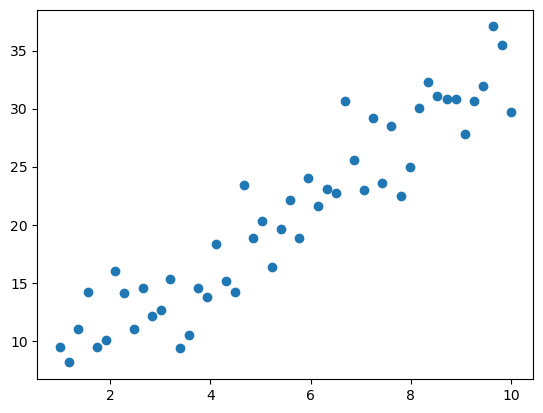

In [ ]:
X, y = generate_tree_dataset(slope=3, intercept=5)

plt.scatter(X, y);

Rappel, forme de la fonction de coût :

- convexe
- ellipses concentriques

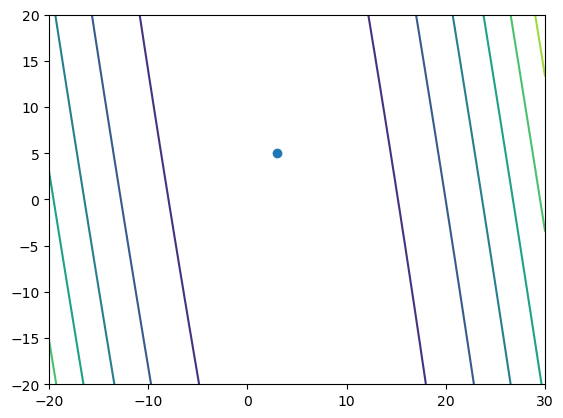

In [57]:
from utils import generate_mse_grid

# grille de paramètres
intercept_vals = np.linspace(-20, 20, 100)
slope_vals = np.linspace(-20, 30, 100)
X, y = generate_tree_dataset(slope=3, intercept=5)

MSE_grid = generate_mse_grid(X, y, intercept_vals, slope_vals)

plt.contour(slope_vals, intercept_vals, MSE_grid)
plt.scatter(3, 5);

Pour améliorer la lisibilité, on scale les données avec un [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), ce qui permet d'avoir des ellipses plus "arrondies". 

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

X, y = generate_tree_dataset(slope=3, intercept=5, add_constant=False)
pipe = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))

pipe.fit(X, y)

a_hat, b_hat = pipe[-1].coef_[0], pipe[-1].intercept_

print("Coefficients estimés sur les données standardisées : ")
print("a : {:.2f}\nb : {:.2f}".format(a_hat, b_hat))

Coefficients estimés sur les données standardisées : 
a : 7.44
b : 20.82


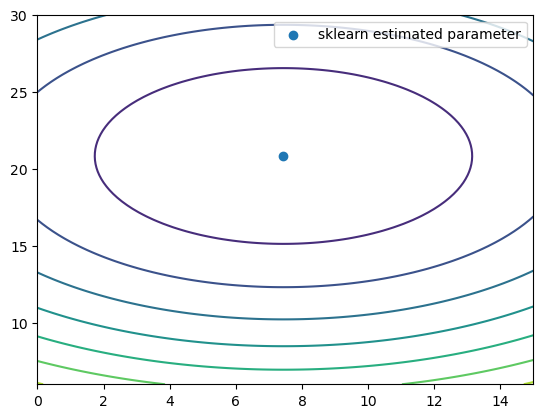

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
slope_vals = np.linspace(0, 15, 100)
intercept_vals = np.linspace(6, 30, 100)

MSE_grid = generate_mse_grid(X_scaled, y, intercept_vals, slope_vals)

plt.contour(slope_vals, intercept_vals, MSE_grid)
plt.scatter(a_hat, b_hat, label="sklearn estimated parameter")
plt.legend();

# 1. Fonctionnement de la descente de gradient 

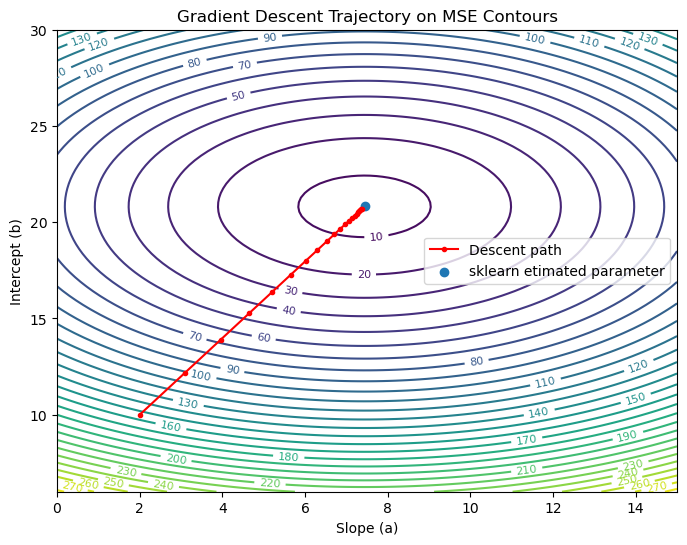

In [78]:
from utils import gradient_mse, gradient_descent

# Run gradient descent
it_hist, grad_hist = gradient_descent(
    gradient_mse, 
    X_scaled, y, 
    initial_condition=(2, 10), 
    lr=0.1, 
    n=20
)

# Extract trajectory of a (slope) and b (intercept)
a_hist = [a for a, b in it_hist]
b_hist = [b for a, b in it_hist]

# Plot contour + trajectory
plt.figure(figsize=(8, 6))
CS = plt.contour(slope_vals, intercept_vals, MSE_grid, levels=30, cmap="viridis")
plt.clabel(CS, inline=1, fontsize=8)

# Trajectory of gradient descent
plt.plot(a_hist, b_hist, marker="o", color="red", markersize=3, linewidth=1.5, label="Descent path")
plt.scatter(a_hat, b_hat, label="sklearn etimated parameter")
plt.xlabel("Slope (a)")
plt.ylabel("Intercept (b)")
plt.title("Gradient Descent Trajectory on MSE Contours")
plt.legend()
plt.show()

Entrées :
- f(θ) : fonction de coût
- ∇f(θ) : gradient de f
- θ₀ : condition initiale
- η : learning rate
- N : nombre d’itérations

Algorithme :
1. Initialiser θ ← θ₀
2. Pour t = 1 → N :
   - Calculer g ← ∇f(θ)
   - Mettre à jour θ ← θ - η * g
3. Retourner θ


# 2. Influence des hyperparmètres

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider, IntSlider

def plot_gradient_descent(a0, b0, lr, n):
    # Condition initiale
    initial_condition = (a0, b0)
    
    # Calcul du gradient descent
    it_hist, grad_hist = gradient_descent(
        gradient_mse, X_scaled, y,
        initial_condition=initial_condition,
        lr=lr,
        n=n
    )
    
    # Historique des paramètres
    a_hist = np.array([a for a, b in it_hist])
    b_hist = np.array([b for a, b in it_hist])
    
    # Norme du gradient
    grad_hist = np.array(grad_hist)
    if grad_hist.ndim == 1:
        grad_norm = np.abs(grad_hist)
    else:
        grad_norm = np.linalg.norm(grad_hist, axis=1)
    
    # Itérations
    traj_iterations = np.arange(len(a_hist))      # pour la trajectoire
    grad_iterations = np.arange(len(grad_norm))   # pour le gradient
    
    # Subplots
    fig, ax = plt.subplots(2, 2, figsize=(14, 6))
    a
    
    # --- Graphe 1: Trajectoire sur les contours ---
    CS = ax[0].contour(slope_vals, intercept_vals, MSE_grid, levels=30, cmap="viridis")
    ax[0].clabel(CS, inline=1, fontsize=8)
    
    sc = ax[0].scatter(a_hist, b_hist, c=traj_iterations, cmap='plasma', s=50, label="Descent path")
    ax[0].plot(a_hist, b_hist, color='gray', linewidth=1, alpha=0.5)
    ax[0].scatter(a_hat, b_hat, label="sklearn estimated parameter", color="blue")
    
    ax[0].set_xlabel("Slope (a)")
    ax[0].set_ylabel("Intercept (b)")
    ax[0].set_title("Gradient Descent Trajectory")
    fig.colorbar(sc, ax=ax[0], label="Iteration")
    ax[0].legend()
    
    # --- Graphe 2: Historique du gradient ---
    ax[1].plot(grad_iterations, grad_norm, marker='o', color='red')
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Gradient Norm")
    ax[1].set_title("Gradient Magnitude per Iteration")
    
    plt.tight_layout()
    plt.show()

# Widgets interactifs
interact(
    plot_gradient_descent,
    a0=FloatSlider(value=2, min=-10, max=10, step=0.1, description="Initial slope (a0)"),
    b0=FloatSlider(value=10, min=-10, max=10, step=0.1, description="Initial intercept (b0)"),
    lr=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description="Learning rate"),
    n=IntSlider(value=20, min=1, max=100, step=1, description="Iterations")
)



interactive(children=(FloatSlider(value=2.0, description='Initial slope (a0)', max=10.0, min=-10.0), FloatSlid…

<function __main__.plot_gradient_descent(a0, b0, lr, n)>

<p align="center">
  <img src="./img/gd_lr_impact.png" alt="plot" width="50%"/>
</p>

source : Dieuleveut

# 3. Un exemple sur des données arbitraires

> Maintenant que l'on a vu comment bien paramètrer un modèle de régression linéaire, l'enjeu est de pouvoir l'utiliser et de s'assurer qu'il est performant. Ce sera l'objet du cours de demain : **évaluer un modèle linéaire**

Ressources : 

- Cette [excellente vidéo](https://www.youtube.com/watch?v=IHZwWFHWa-w) de 3 Blue 1 Brown, toute la chaîne vaut le détour
- L'idée du widget vient de [cette vidéo](https://www.youtube.com/watch?v=yLz1NELcIM0) de Probabl, un spin-off de scikit-learn qui diffuse des vidéos d'explication sur le ML
- La documentation de scikit-learn est très bien faite

- Toujours dans le registre des vidéos Youtube, vous pouvez aller voir : 
  - 3Blue1Brown
  - MachineLearnia
  - Statquest